## Download Data

In [1]:
from datasets import load_dataset

# train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
train_set = load_dataset('cifar10', split='train')
test_set = load_dataset('cifar10', split='test')
splits = train_set.train_test_split(test_size=0.2)
train_set = splits['train']
val_set = splits['test']

In [24]:
print(type(train_set))
# train_set[0:20]

<class 'datasets.arrow_dataset.Dataset'>


In [3]:
train_set.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

## Preprocessing

In [4]:
from transformers import ViTImageProcessor, BeitImageProcessor

processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')

In [5]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
transform_train = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

transform_val = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [transform_train(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [transform_val(image.convert("RGB")) for image in examples['img']]
    return examples

In [6]:
train_set.set_transform(train_transforms)
val_set.set_transform(val_transforms)
test_set.set_transform(val_transforms)

## Define the model

In [7]:
id2label = {id:label for id, label in enumerate(train_set.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

In [8]:
from transformers import BeitForImageClassification

model = BeitForImageClassification.from_pretrained\
    ('microsoft/beit-base-patch16-224',
     id2label=id2label,
     label2id=label2id,
     ignore_mismatched_sizes=True)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model = model.cuda()

In [10]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [11]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"checkpoints",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [12]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [13]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

## Train the model

In [14]:
print(next(model.parameters()).device)


cuda:0


In [15]:
trainer.train()


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=12000, training_loss=0.33777253341674807, metrics={'train_runtime': 2433.7102, 'train_samples_per_second': 49.307, 'train_steps_per_second': 4.931, 'total_flos': 9.29573099126784e+18, 'train_loss': 0.33777253341674807, 'epoch': 3.0})

In [16]:
test_outputs = trainer.predict(test_set)

acurracy 0.9887
precision 0.9887264654119624
recall 0.9886999999999999
f1_score 0.9886959341990476


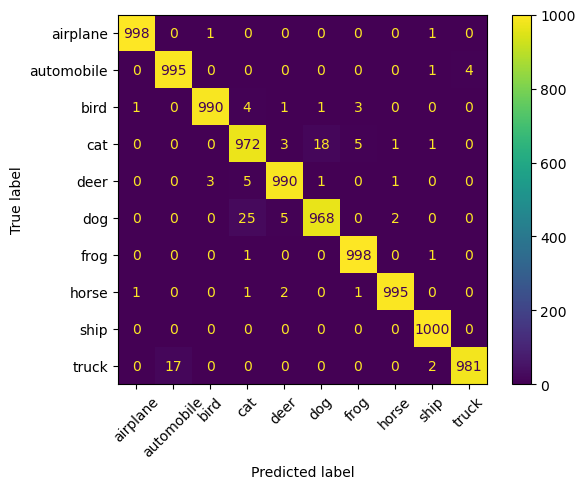

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

print("acurracy", accuracy_score(y_true, y_pred))
print("precision", precision_score(y_true, y_pred, average='macro'))
print("recall", recall_score(y_true, y_pred, average='macro'))
print("f1_score", f1_score(y_true, y_pred, average='macro'))



labels = test_set.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

NameError: name 'time' is not defined